# Code

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import pickle
import math
import torch
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import DataLoader
# if its_jupyter_notebook:
#     sys.argv = [''] #Remove this if it's not a jupyter notebook!

import sys
sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    plot_sample,
    #plot_sample2,
    seed_everything,
)
from config import *

In [2]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, "df_genes.csv"))
df = pd.read_csv(os.path.join(processed_files_dir, "final_df.csv"))

In [3]:
#the N in the cdna creates problem with the tokenizer
df_genes['problematic_set'] = df_genes['cdna'].apply(lambda x: False if (set(x) - set({'A', 'C', 'G', 'T'}) == set()) else True)
genesN = set(df_genes[df_genes.problematic_set].gene_id.values)
print(f'{len(genesN)} genes have N, so will be excluded')
df = df[~(df.gene1.isin(genesN))|(df.gene2.isin(genesN))].reset_index(drop = True)

2 genes have N, so will be excluded


In [4]:
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_training.txt"), "rb") as fp:  # Unpickling
    subset_train = pickle.load(fp)
    subset_train = pd.Series(subset_train).str.split('_', expand = True)
    genes_train = set(subset_train[0]).union(set(subset_train[1]))

In [5]:
limit_small_rna = 7000
limit_medium_rna = 8500

print('MAX_RNA_SIZE is', MAX_RNA_SIZE)
print('limit of small rna is:', limit_small_rna)
print('limit of medium rna is:', limit_medium_rna)

small1 = df[(df.length_2<=limit_small_rna)&(df.length_1<=limit_medium_rna)] #both small and one small the other medium
small2 = df[(df.length_1<=limit_small_rna)&(df.length_2<=limit_medium_rna)] #both small and one small the other medium
df_small = pd.concat([small1, small2], axis = 0).drop_duplicates().reset_index(drop = True) #one small the other medium

df_big = df[(df.length_1>limit_medium_rna)&(df.length_2>limit_medium_rna)].reset_index(drop=True)

df_medium = df[~df.couples.isin(set(df_small.couples).union(set(df_big.couples)))].reset_index(drop=True)
assert (df_small.shape[0]+df_medium.shape[0]+df_big.shape[0]) == df.shape[0]
set(df_small.couples).union(set(df_medium.couples)).union(set(df_big.couples)) == set(df.couples)
perc_small = np.round(df_small.shape[0]/df.shape[0]*100, 1)
perc_medium = np.round(df_medium.shape[0]/df.shape[0]*100, 1)
perc_big = np.round(df_big.shape[0]/df.shape[0]*100, 1)
print(f'The amount of contact matrixes (in the entire dataset) that are small is {perc_small}% ')
print(f'The amount of contact matrixes (in the entire dataset) that are medium is {perc_medium}% ')
print(f'The amount of contact matrixes (in the entire dataset) that are big is {perc_big}% ')

MAX_RNA_SIZE is 5970
limit of small rna is: 7000
limit of medium rna is: 8500
The amount of contact matrixes (in the entire dataset) that are small is 76.1% 
The amount of contact matrixes (in the entire dataset) that are medium is 22.1% 
The amount of contact matrixes (in the entire dataset) that are big is 1.8% 


In [6]:
def create_sample_dict(id_couple, sample):
    """
    x1, x2, y1, y2 is where is the interaction with respect to the actual coordinates (not the original coordinates)
    length_1, length_2 is the length with respect to the actual length (not the original length)
    
    original_x1, original_x2, original_y1, original_y2 is where the rna interacts with respect to original coordinates 
    window_x1, window_x2, window_y1, window_y2 is where the rna was sampled with respect to original coordinates 
    original_length1, original_length2 is the original length
    """
    d = {
        'id_sample':id_couple,
        'couples':sample.couple_id,
        'gene1':sample.gene1,
        'gene2':sample.gene2,
        'interacting':sample.interacting,
        'length_1':sample.bbox.x2-sample.bbox.x1,
        'length_2':sample.bbox.y2-sample.bbox.y1,
        'protein_coding_1':sample.gene1_info["protein_coding"],
        'protein_coding_2':sample.gene2_info["protein_coding"],
        'x1': sample.seed_interaction_bbox.x1 - sample.bbox.x1,
        'x2': sample.seed_interaction_bbox.x2 - sample.bbox.x1,
        'y1': sample.seed_interaction_bbox.y1 - sample.bbox.y1,
        'y2': sample.seed_interaction_bbox.y2 - sample.bbox.y1,
        'policy':sample.policy,
        'cdna1':sample.gene1_info["cdna"][sample.bbox.x1:sample.bbox.x2],
        'cdna2':sample.gene2_info["cdna"][sample.bbox.y1:sample.bbox.y2],
        'original_x1':sample.seed_interaction_bbox.x1,
        'original_x2':sample.seed_interaction_bbox.x2,
        'original_y1':sample.seed_interaction_bbox.y1,
        'original_y2':sample.seed_interaction_bbox.y2,
        'window_x1':sample.bbox.x1,
        'window_x2':sample.bbox.x2,
        'window_y1':sample.bbox.y1,
        'window_y2':sample.bbox.y2,
        'original_length1':len(sample.gene1_info["cdna"]),
        'original_length2':len(sample.gene2_info["cdna"]),
        'id_gene1_sample':sample.gene1 + '_' + str(sample.bbox.x1) + '_' + str(sample.bbox.x2),
        'id_gene2_sample':sample.gene2 + '_' + str(sample.bbox.y1) + '_' + str(sample.bbox.y2)
    }
    return d

def get_dataset(ep_per_sample, sn_per_sample, en_persample, hn_per_sample, df_genes, df, subset_file, pos_width_multipliers, pos_height_multipliers, neg_width_windows, neg_height_windows):
    assert np.round(sum(pos_width_multipliers.values()), 4) == np.round(sum(neg_width_windows.values()), 4) == 1
    
    pol = []
    
    if ep_per_sample>0:
        pol.append(
            EasyPosAugment(
            per_sample=ep_per_sample,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_height_multipliers,
            )
        )
        
    if sn_per_sample>0:
        pol.append(   
            SmartNegAugment(
                per_sample=sn_per_sample,
                interaction_selection=InteractionSelectionPolicy.LARGEST,
                width_multipliers=pos_width_multipliers,
                height_multipliers=pos_height_multipliers,
            )
        )
        
    if en_persample>0:
        pol.append( 
            EasyNegAugment(
                per_sample=en_persample,
                width_windows=neg_width_windows,
                height_windows=neg_height_windows,
            )
        )
        
    if hn_per_sample>0:
        pol.append(
            HardNegAugment(
                per_sample=hn_per_sample,
                width_windows=neg_width_windows,
                height_windows=neg_height_windows,
            )
        )
        
    dataset = RNADataset(
            gene2info=df_genes,
            interactions=df,
            subset_file=subset_file,
            augment_policies=pol,
    )
    return dataset 

In [7]:
pos_width_multipliers = {1_000_000: 1.}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

In [8]:
#small policies
ep_per_sample_small=1
sn_per_sample_small=1
en_per_sample_small=0
hn_per_sample_small=0

#medium policies
ep_per_sample_medium=2
sn_per_sample_medium=2
en_per_sample_medium=0
hn_per_sample_medium=0


#big policies
ep_per_sample_big=3
sn_per_sample_big=3
en_per_sample_big=0
hn_per_sample_big=0

In [9]:
tot_ep = ep_per_sample_small*perc_small + ep_per_sample_medium*perc_medium + ep_per_sample_big*perc_big
tot_sn = sn_per_sample_small*perc_small + sn_per_sample_medium*perc_medium + sn_per_sample_big*perc_big
tot_en = en_per_sample_small*perc_small + en_per_sample_medium*perc_medium + en_per_sample_big*perc_big
tot_hn = hn_per_sample_small*perc_small + hn_per_sample_medium*perc_medium + hn_per_sample_big*perc_big

tot_neg = tot_sn + tot_en + tot_hn
print(f'expected smartneg are the {np.round( tot_sn/tot_neg *100, 2)}% of negative pairs')
print(f'expected easyneg are the {np.round( tot_en/tot_neg *100, 2)}% of negative pairs')
print(f'expected hardneg are the {np.round( tot_hn/tot_neg *100, 2)}% of negative pairs')

unbalanced_factor = df[df.interacting == False].shape[0]/df.shape[0]
expected_uf = tot_ep*unbalanced_factor / ((tot_ep*unbalanced_factor) + tot_neg)
print(f'expected unbalanced factor is {np.round(expected_uf*100, 2)}%')

expected smartneg are the 100.0% of negative pairs
expected easyneg are the 0.0% of negative pairs
expected hardneg are the 0.0% of negative pairs
expected unbalanced factor is 39.83%


# Data loader train

In [10]:
set_data = 'training' 
assert set_data in ['training', 'val', 'test']
subset_file = os.path.join(rna_rna_files_dir, f"gene_pairs_{set_data}.txt")

id_couple = 0
meta = {}

In [11]:
start_time = time.time()

small = get_dataset(ep_per_sample=ep_per_sample_small, sn_per_sample=sn_per_sample_small, 
                    en_persample=en_per_sample_small, hn_per_sample=hn_per_sample_small, 
                    df_genes=df_genes, df=df_small, subset_file=subset_file, 
                    pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                    neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small), total = len(small)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium = get_dataset(ep_per_sample=ep_per_sample_medium, sn_per_sample=sn_per_sample_medium,
                     en_persample=en_per_sample_medium, hn_per_sample=hn_per_sample_medium, 
                     df_genes=df_genes, df=df_medium, subset_file=subset_file,
                     pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                     neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium), total = len(medium)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big = get_dataset(ep_per_sample=ep_per_sample_big, sn_per_sample=sn_per_sample_big, 
                  en_persample=en_per_sample_big, hn_per_sample=hn_per_sample_big, 
                  df_genes=df_genes, df=df_big, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big), total = len(big)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
def df_meta_from_meta_dict(meta, do_controls = True):
    df_meta = pd.DataFrame.from_dict(meta, 'index')
    df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
    df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
    if do_controls:
        assert (df_meta['lencdna1'] == df_meta['length_1']).all()
        assert (df_meta['lencdna2'] == df_meta['length_2']).all()
        assert ((df_meta.window_x2 - df_meta.window_x1)==(df_meta.lencdna1)).all()
        assert ((df_meta.window_y2 - df_meta.window_y1)==(df_meta.lencdna2)).all()
    df_meta = df_meta.drop(['lencdna1', 'lencdna2'], axis = 1)
    if do_controls:
        m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
        assert (m.x1 >= 0).all()
        assert (m.y1 >= 0).all()
        assert (m.x2 <= m.length_1).all()
        assert (m.y2 <= m.length_2).all()

        assert df_meta[df_meta.length_1==df_meta.original_length1][['gene1', 'id_gene1_sample']].groupby('gene1').nunique().max().iloc[0] == 1
        assert df_meta[df_meta.length_2==df_meta.original_length2][['gene2', 'id_gene2_sample']].groupby('gene2').nunique().max().iloc[0] == 1
    return df_meta

df_meta = df_meta_from_meta_dict(meta, do_controls = True)
print(f"Total time to create datasets: {(time.time()-start_time)/60} minutes")

  0%|          | 0/130720 [00:00<?, ?it/s]

  0%|          | 0/77896 [00:00<?, ?it/s]

  0%|          | 0/9435 [00:00<?, ?it/s]

Total time to create datasets: 0.5959359804789225 minutes


93092 14845
6.2709329740653414
smartneg


/data01/giorgio/RNARNA-NT/src/../dataset/data.py:1324: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot([0, width],[0, height], 'ro', color = 'white')


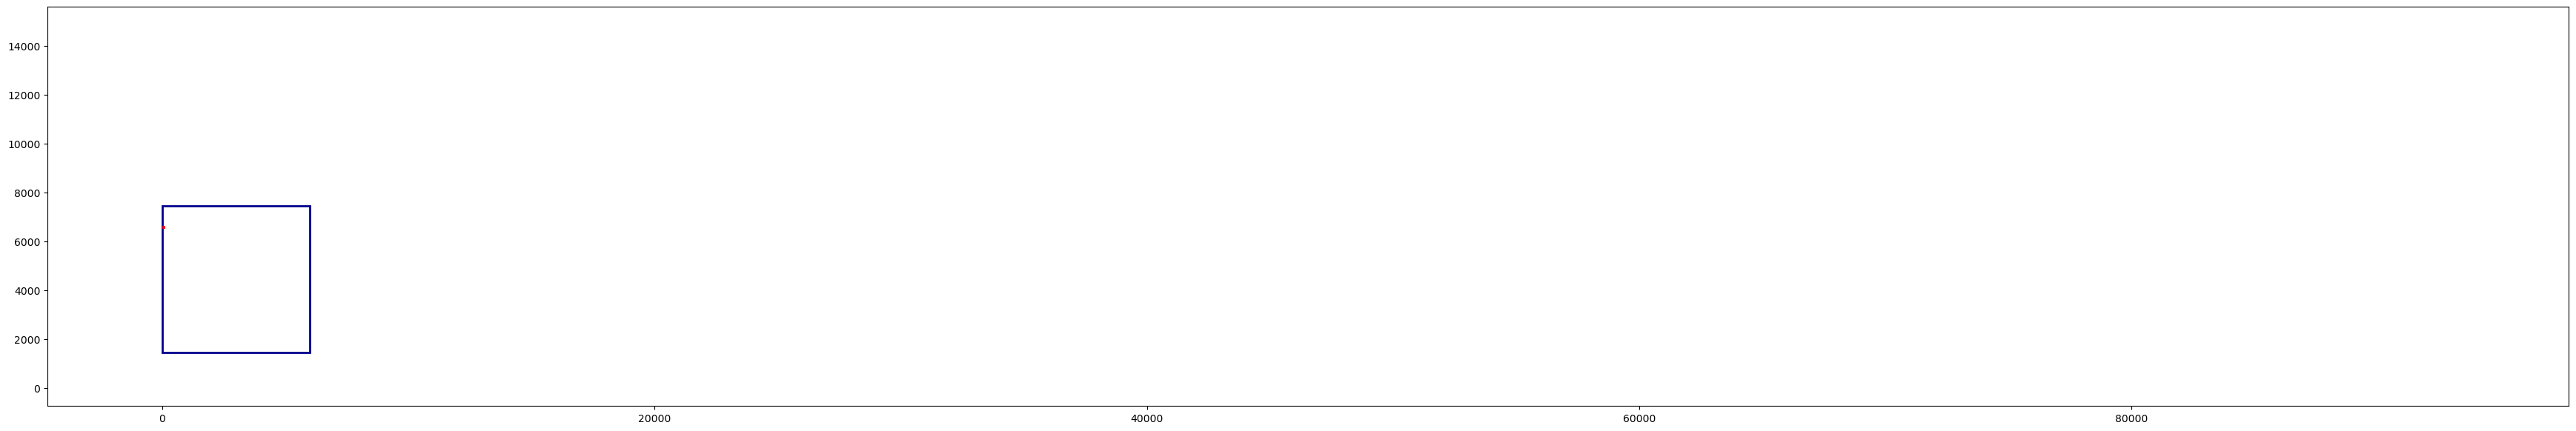

In [12]:
plot_sample(sample, True)
print(sample.policy)

### Controllo se alcuni geni hanno un arricchimento solo nei positivi o solo nei negativi.

In [13]:
def balance_df(df):
    positives = df[df.interacting]
    negatives = df[df.interacting == False]
    if negatives.shape[0]>=positives.shape[0]:
        negatives_to_sample = positives.shape[0]
        df_sampled = pd.concat([positives, negatives.sample(negatives_to_sample)],axis = 0)
    else:
        positives_to_sample = negatives.shape[0]
        df_sampled = pd.concat([negatives, positives.sample(positives_to_sample)],axis = 0)
    return df_sampled.reset_index(drop = True)

def obtain_pair_diff_distribution(sampled, gene_count_real):
    sampled = sampled.merge(gene_count_real[['gene', 'diff']], left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff1'}, axis =1)
    sampled = sampled.merge(gene_count_real[['gene', 'diff']], left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff2'}, axis =1)
    sampled['diff'] = sampled['diff1'] + sampled['diff2']
    return sampled

def obtain_gene_count_real(df):
    vc = df.interacting.value_counts()
    if set(vc.index) == {False, True}:
        unbalance_factor = vc[True]/vc[False]
    else:
        unbalance_factor = np.nan
    gene_count_pos_list = list(df[df.interacting].gene1) + list(df[df.interacting].gene2)
    gene_count_neg_list = list(df[df.interacting == False].gene1) + list(df[df.interacting == False].gene2)

    gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
    gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
    gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
    
    gene_count_res['weight'] = 1
    gene_count_res.loc[ gene_count_res.interacting == 0, 'weight'] = unbalance_factor
    gene_count_real = gene_count_res.groupby('gene').sum()
    gene_count_real['not_interacting'] = gene_count_real['weight'] - gene_count_real['interacting']
    gene_count_real['diff'] = gene_count_real['interacting'] - gene_count_real['not_interacting']
    gene_count_real['total'] = gene_count_real['not_interacting'] + gene_count_real['interacting']
    gene_count_real = gene_count_real.reset_index()#add gene column
    return gene_count_real

In [14]:
gene_count = obtain_gene_count_real(df_meta)
df_meta = obtain_pair_diff_distribution(df_meta, gene_count)

In [15]:
print(df_meta.shape[0])

218051


#### Simulate

  0%|          | 0/30 [00:00<?, ?it/s]

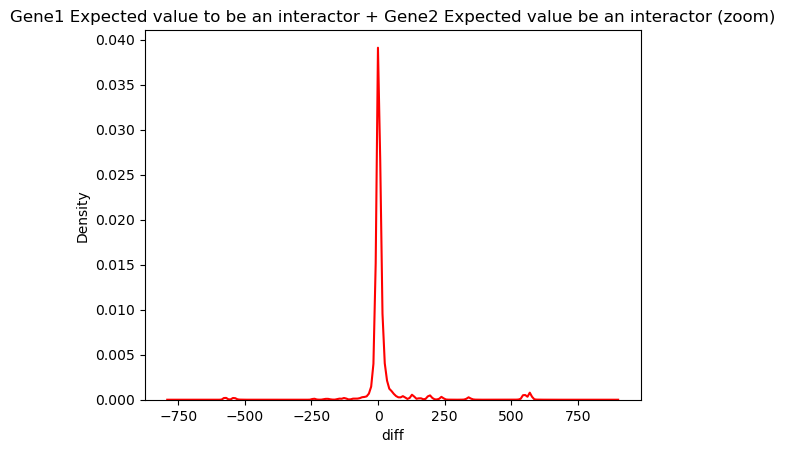

In [16]:
n_epochs = 30
couples = []
interactings = []
for i in tqdm(range(n_epochs)):
    train_sampled = balance_df(df_meta.copy().drop(['diff1', 'diff2', 'diff'], axis = 1))
    couples += list(train_sampled.couples)
    interactings += list(train_sampled.interacting)

res = pd.DataFrame({'couples':couples, 'interactings':interactings})
new_cols = res.couples.str.extractall('(.*)_(.*)')
res['gene1'] = new_cols.reset_index()[0]
res['gene2'] = new_cols.reset_index()[1]

gene_count_pos_list = list(res[res.interactings].gene1) + list(res[res.interactings].gene2)
gene_count_neg_list = list(res[res.interactings == False].gene1) + list(res[res.interactings == False].gene2)
gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
gene_count_res['n'] = 1
gene_count_real = gene_count_res.groupby('gene').sum()
gene_count_real['not_interacting'] = gene_count_real['n'] - gene_count_real['interacting']
gene_count_real['diff'] = gene_count_real['interacting'] - gene_count_real['not_interacting']
gene_count_real = gene_count_real.reset_index()

res = obtain_pair_diff_distribution(res, gene_count_real)

sns.kdeplot(res['diff']/n_epochs, color = 'red', label = 'empirical')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor (zoom)')
plt.show()

In [17]:
# n_epochs = 30

# def update_df(updt_df, subsetted_sampled):
#     subsetted_sampled = subsetted_sampled[['couples', 'diff1', 'diff2']].reset_index(drop = True)
#     subsetted_sampled['diff'] = subsetted_sampled['diff1'] + subsetted_sampled['diff2'] 
#     gb1 = subsetted_sampled.groupby('couples').sum().reset_index() #this is to sum the effect of duplicated couples
#     gb2 = subsetted_sampled.groupby('couples').count().reset_index()[['couples', 'diff']].rename({'diff':'n'}, axis = 1)
#     subsetted_sampled = gb1.merge(gb2, on = 'couples')
#     merged_df = updt_df.merge(subsetted_sampled[['couples', 'diff', 'n']], on = 'couples', how='left').fillna(0)
#     merged_df['diff'] = merged_df['diff_x'] + merged_df['diff_y']
#     merged_df['n'] = merged_df['n_x'] + merged_df['n_y']
#     return merged_df[['couples', 'diff', 'n']]

# updt_df = pd.DataFrame(df_meta.couples).drop_duplicates().reset_index(drop=True)
# updt_df['diff'] = 0
# updt_df['n'] = 0

# for i in tqdm(range(n_epochs)):
#     train_sampled = balance_df(df_meta.copy().drop(['diff1', 'diff2', 'diff'], axis = 1))
#     gene_count_real = obtain_gene_count_real(train_sampled)
#     train_sampled = obtain_pair_diff_distribution(train_sampled, gene_count_real)
#     updt_df = update_df(updt_df, train_sampled)

# updt_df['n_per_epochs'] = updt_df['n']/n_epochs
# updt_df['diff_weigthed'] = (updt_df['n_per_epochs'] * updt_df['diff'])/n_epochs
    
# sns.kdeplot(updt_df['diff_weigthed'], color = 'red', label = 'empirical')
# sns.kdeplot(df_meta['diff'], color = 'blue', label = 'theorical')
# plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
# plt.legend()
# plt.show()

# sns.kdeplot(updt_df[(updt_df['diff'] > 1)]['diff_weigthed'], color = 'red', label = 'empirical')
# sns.kdeplot(df_meta[df_meta['diff'] > 1]['diff'], color = 'blue', label = 'theorical')
# plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor (zoom)')
# plt.legend()
# plt.show()

# sns.kdeplot(updt_df[(updt_df['diff']<-1)]['diff_weigthed'], color = 'red', label = 'empirical')
# sns.kdeplot(df_meta[df_meta['diff'] < - 1]['diff'], color = 'blue', label = 'theorical')
# plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor (zoom)')
# plt.legend()
# plt.show()

In [18]:
EXCLUDE_SMALL_RNA = False
genes_to_exclude = []#list(gene_count[(gene_count['diff'] <- 30)|(gene_count['diff'] > 30)].gene) #I don't want to oversample pairs where these gene are present, since I cannot adjust them.

In [19]:
they_need_smartneg = df_meta[(df_meta['diff1']>0.7) & (df_meta['diff2']>0.7)]
they_need_smartneg = they_need_smartneg[~(
    (they_need_smartneg['gene1'].isin(genes_to_exclude))|(they_need_smartneg['gene2'].isin(genes_to_exclude)) 
)]
they_need_easypos = df_meta[(df_meta['diff1']<-0.7) & (df_meta['diff2']<-0.7)]
they_need_easypos = they_need_easypos[~(
    (they_need_easypos['gene1'].isin(genes_to_exclude))|(they_need_easypos['gene2'].isin(genes_to_exclude)) 
)]

if EXCLUDE_SMALL_RNA:
    #filter out small rna, where I don't want to sample more
    they_need_smartneg = they_need_smartneg[~(
        (they_need_smartneg.original_length2<=limit_small_rna)&(they_need_smartneg.original_length1<=limit_medium_rna)
    )]
    they_need_smartneg = they_need_smartneg[~(
        (they_need_smartneg.original_length1<=limit_small_rna)&(they_need_smartneg.original_length2<=limit_medium_rna)
    )]


    they_need_easypos = they_need_easypos[~(
        (they_need_easypos.original_length2<=limit_small_rna)&(they_need_easypos.original_length1<=limit_medium_rna)
    )]
    they_need_easypos = they_need_easypos[~(
        (they_need_easypos.original_length1<=limit_small_rna)&(they_need_easypos.original_length2<=limit_medium_rna)
    )]

#filter out easypos if the need smartneg and viceversa

they_need_smartneg = they_need_smartneg[(they_need_smartneg.policy == 'smartneg')]
they_need_easypos = they_need_easypos[(they_need_easypos.policy == 'easypos')]

they_need_smartneg['min_diff'] = they_need_smartneg.apply(lambda x: min(x.diff1, x.diff2), axis = 1 )
they_need_easypos['max_diff'] = they_need_easypos.apply(lambda x: max(x.diff1, x.diff2), axis = 1 )

In [ ]:
# create smartnegs

start_time = time.time()

value = they_need_smartneg['min_diff'].max()
while value > 0.7:
    new_query = df[df.couples.isin(list(they_need_smartneg['couples']))].sample(frac = 1).drop_duplicates(subset=['couples'])
    
    data = get_dataset(ep_per_sample=0, sn_per_sample=1, 
                  en_persample=0, hn_per_sample=0, 
                  df_genes=df_genes, df=new_query, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

    for i, sample in enumerate(data):
        meta[id_couple] = create_sample_dict(id_couple, sample)
        id_couple += 1
    
    df_meta = df_meta_from_meta_dict(meta, do_controls = False)
    
    gene_count = obtain_gene_count_real(df_meta)
    df_meta = obtain_pair_diff_distribution(df_meta, gene_count)
    
    they_need_smartneg = df_meta[(df_meta['diff1']>0.7) & (df_meta['diff2']>0.7)]
    they_need_smartneg = they_need_smartneg[~(
        (they_need_smartneg['gene1'].isin(genes_to_exclude))|(they_need_smartneg['gene2'].isin(genes_to_exclude)) 
    )]

    if EXCLUDE_SMALL_RNA:
        #filter out small rna, where I don't want to sample more
        they_need_smartneg = they_need_smartneg[~(
            (they_need_smartneg.original_length2<=limit_small_rna)&(they_need_smartneg.original_length1<=limit_medium_rna)
        )]
        they_need_smartneg = they_need_smartneg[~(
            (they_need_smartneg.original_length1<=limit_small_rna)&(they_need_smartneg.original_length2<=limit_medium_rna)
        )]
    
    they_need_smartneg = they_need_smartneg[(they_need_smartneg.policy == 'smartneg')]
    they_need_smartneg['min_diff'] = they_need_smartneg.apply(lambda x: min(x.diff1, x.diff2), axis = 1 )
    
    value = they_need_smartneg['min_diff'].max()
    print('value:', value)
    
print(f"Total time to adjust datasets: {(time.time()-start_time)/60} minutes")

value: 197.29043829814543
value: 195.9852815869649
value: 196.02914953819868
value: 194.17588407957885
value: 192.43800546759314
value: 190.70061306176217
value: 188.13106915017977
value: 185.89426214522757
value: 185.06294831252683
value: 183.2772700108011


In [ ]:
# create easypos

start_time = time.time()

value = they_need_easypos['max_diff'].min()
while value < - 0.7:
    new_query = df[df.couples.isin(list(they_need_easypos['couples']))].sample(frac = 1).drop_duplicates(subset=['couples'])
    
    data = get_dataset(ep_per_sample=1, sn_per_sample=0, 
                  en_persample=0, hn_per_sample=0, 
                  df_genes=df_genes, df=new_query, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

    for i, sample in enumerate(data):
        meta[id_couple] = create_sample_dict(id_couple, sample)
        id_couple += 1
    
    df_meta = df_meta_from_meta_dict(meta, do_controls = False)
    
    gene_count = obtain_gene_count_real(df_meta)
    df_meta = obtain_pair_diff_distribution(df_meta, gene_count)
    
    they_need_easypos = df_meta[(df_meta['diff1']<-0.7) & (df_meta['diff2']<-0.7)]
    they_need_easypos = they_need_easypos[~(
        (they_need_easypos['gene1'].isin(genes_to_exclude))|(they_need_easypos['gene2'].isin(genes_to_exclude)) 
    )]

    #filter out small rna, where I don't want to sample more
    if EXCLUDE_SMALL_RNA:
        they_need_easypos = they_need_easypos[~(
            (they_need_easypos.original_length2<=limit_small_rna)&(they_need_easypos.original_length1<=limit_medium_rna)
        )]
        they_need_easypos = they_need_easypos[~(
            (they_need_easypos.original_length1<=limit_small_rna)&(they_need_easypos.original_length2<=limit_medium_rna)
        )]
    
    they_need_easypos = they_need_easypos[(they_need_easypos.policy == 'easypos')]
    
    they_need_easypos['max_diff'] = they_need_easypos.apply(lambda x: max(x.diff1, x.diff2), axis = 1 )
    
    value = they_need_easypos['max_diff'].min()
    print('value:', value)
    
print(f"Total time to adjust datasets: {(time.time()-start_time)/60} minutes")

In [ ]:
print('# of total sample', df_meta.shape[0])
print('# of duplicates that help degree balance', df_meta[
    df_meta.apply(lambda x: ''.join(sorted([x.id_gene1_sample, x.id_gene2_sample])), axis = 1).duplicated()
].shape[0])

#### Simulate 

In [ ]:
couples = []
interactings = []
for i in tqdm(range(n_epochs)):
    train_sampled = balance_df(df_meta.copy().drop(['diff1', 'diff2', 'diff'], axis = 1))
    couples += list(train_sampled.couples)
    interactings += list(train_sampled.interacting)

res = pd.DataFrame({'couples':couples, 'interactings':interactings})
new_cols = res.couples.str.extractall('(.*)_(.*)')
res['gene1'] = new_cols.reset_index()[0]
res['gene2'] = new_cols.reset_index()[1]

gene_count_pos_list = list(res[res.interactings].gene1) + list(res[res.interactings].gene2)
gene_count_neg_list = list(res[res.interactings == False].gene1) + list(res[res.interactings == False].gene2)
gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
gene_count_res['n'] = 1
gene_count_real = gene_count_res.groupby('gene').sum()
gene_count_real['not_interacting'] = gene_count_real['n'] - gene_count_real['interacting']
gene_count_real['diff'] = gene_count_real['interacting'] - gene_count_real['not_interacting']
gene_count_real = gene_count_real.reset_index()

res = obtain_pair_diff_distribution(res, gene_count_real)

sns.kdeplot(res['diff']/n_epochs, color = 'red', label = 'empirical')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor (zoom)')
plt.show()

#### Hardneg, Easyneg for training

In [ ]:
#small policies
ep_per_sample_small=0
sn_per_sample_small=0
en_per_sample_small=0
hn_per_sample_small=0

#medium policies
ep_per_sample_medium=0
sn_per_sample_medium=0
en_per_sample_medium=0.5
hn_per_sample_medium=0.5


#big policies
ep_per_sample_big=0
sn_per_sample_big=0
en_per_sample_big=1
hn_per_sample_big=1

In [ ]:
start_time = time.time()

small = get_dataset(ep_per_sample=ep_per_sample_small, sn_per_sample=sn_per_sample_small, 
                    en_persample=en_per_sample_small, hn_per_sample=hn_per_sample_small, 
                    df_genes=df_genes, df=df_small, subset_file=subset_file, 
                    pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                    neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small), total = len(small)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium = get_dataset(ep_per_sample=ep_per_sample_medium, sn_per_sample=sn_per_sample_medium,
                     en_persample=en_per_sample_medium, hn_per_sample=hn_per_sample_medium, 
                     df_genes=df_genes, df=df_medium, subset_file=subset_file,
                     pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                     neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium), total = len(medium)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big = get_dataset(ep_per_sample=ep_per_sample_big, sn_per_sample=sn_per_sample_big, 
                  en_persample=en_per_sample_big, hn_per_sample=hn_per_sample_big, 
                  df_genes=df_genes, df=df_big, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big), total = len(big)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
print(f"Total time to create easyneg, hardneg: {(time.time()-start_time)/60} minutes")

In [ ]:
df_meta = df_meta_from_meta_dict(meta, do_controls = False)

In [ ]:
tot_ep = (df_meta.policy == 'easypos').sum()
tot_sn = (df_meta.policy == 'smartneg').sum()
tot_en = (df_meta.policy == 'easyneg').sum()
tot_hn = (df_meta.policy == 'hardneg').sum()
tot_neg = (df_meta.interacting == False).sum()
assert tot_ep == (df_meta.interacting == True).sum()
assert tot_neg == tot_en+tot_sn+tot_hn
print(f'actual smartneg are the {np.round( tot_sn/tot_neg *100, 2)}% of negative pairs')
print(f'actual easyneg are the {np.round( tot_en/tot_neg *100, 2)}% of negative pairs')
print(f'actual hardneg are the {np.round( tot_hn/tot_neg *100, 2)}% of negative pairs')

print(f'actual unbalanced factor is {np.round( (tot_ep/(tot_ep+tot_neg))*100, 2)}%')

In [ ]:
assert (df_meta.id_gene1_sample.str.extract('(.*)_(.*)_(.*)')[0] == df_meta.gene1).all()
assert (df_meta.id_gene2_sample.str.extract('(.*)_(.*)_(.*)')[0] == df_meta.gene2).all()

In [ ]:
df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}.csv'), index = False)

# Data Loader val

In [ ]:
#small policies
ep_per_sample_small=1
sn_per_sample_small=1
en_per_sample_small=0
hn_per_sample_small=0

#medium policies
ep_per_sample_medium=2
sn_per_sample_medium=2
en_per_sample_medium=0.2
hn_per_sample_medium=0.3


#big policies
ep_per_sample_big=4
sn_per_sample_big=4
en_per_sample_big=0.5
hn_per_sample_big=1

In [ ]:
#small policies
ep_per_sample_small=1
sn_per_sample_small=1
en_per_sample_small=0
hn_per_sample_small=0

#medium policies
ep_per_sample_medium=2
sn_per_sample_medium=2
en_per_sample_medium=0.2
hn_per_sample_medium=0.3


#big policies
ep_per_sample_big=3
sn_per_sample_big=3
en_per_sample_big=0.5
hn_per_sample_big=1

In [32]:
set_data = 'val' 
assert set_data in ['training', 'val', 'test']
subset_file = os.path.join(rna_rna_files_dir, f"gene_pairs_{set_data}.txt")

meta = {}

In [33]:
start_time = time.time()

small = get_dataset(ep_per_sample=ep_per_sample_small, sn_per_sample=sn_per_sample_small, 
                    en_persample=en_per_sample_small, hn_per_sample=hn_per_sample_small, 
                    df_genes=df_genes, df=df_small, subset_file=subset_file, 
                    pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                    neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small), total = len(small)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium = get_dataset(ep_per_sample=ep_per_sample_medium, sn_per_sample=sn_per_sample_medium,
                     en_persample=en_per_sample_medium, hn_per_sample=hn_per_sample_medium, 
                     df_genes=df_genes, df=df_medium, subset_file=subset_file,
                     pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                     neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium), total = len(medium)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big = get_dataset(ep_per_sample=ep_per_sample_big, sn_per_sample=sn_per_sample_big, 
                  en_persample=en_per_sample_big, hn_per_sample=hn_per_sample_big, 
                  df_genes=df_genes, df=df_big, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big), total = len(big)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
df_meta = pd.DataFrame.from_dict(meta, 'index')
df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
assert (df_meta['lencdna1'] == df_meta['length_1']).all()
assert (df_meta['lencdna2'] == df_meta['length_2']).all()
assert ((df_meta.window_x2 - df_meta.window_x1)==(df_meta.lencdna1)).all()
assert ((df_meta.window_y2 - df_meta.window_y1)==(df_meta.lencdna2)).all()
df_meta = df_meta.drop(['lencdna1', 'lencdna2'], axis = 1)

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.x1 >= 0).all()
assert (m.y1 >= 0).all()
assert (m.x2 <= m.length_1).all()
assert (m.y2 <= m.length_2).all()

assert df_meta[df_meta.length_1==df_meta.original_length1][['gene1', 'id_gene1_sample']].groupby('gene1').nunique().max().iloc[0] == 1
assert df_meta[df_meta.length_2==df_meta.original_length2][['gene2', 'id_gene2_sample']].groupby('gene2').nunique().max().iloc[0] == 1

print(f"Total time to create datasets: {(time.time()-start_time)/60} minutes")

  0%|          | 0/25613 [00:00<?, ?it/s]

  0%|          | 0/15984 [00:00<?, ?it/s]

  0%|          | 0/2838 [00:00<?, ?it/s]

Total time to create datasets: 0.7954792579015096 minutes


In [34]:
df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}.csv'), index = False)

I have to undersample df_meta because I want a balanced validation set. I will exclude easyneg, hardneg and smartneg where both genes are in the training set.

In [35]:
df_meta = df_meta[df_meta.policy.isin(['smartneg','easypos'])]
df_not_in_train = df_meta[~( (df_meta.gene1.isin(genes_train))|(df_meta.gene2.isin(genes_train)) )]
n_to_exclude = df_meta.interacting.value_counts()[False] - df_meta.interacting.value_counts()[True]
df_to_sample = df_meta[(df_meta.gene1.isin(genes_train))&(df_meta.gene2.isin(genes_train))&(df_meta.interacting == False)]
ids_to_eclude = set(df_to_sample.sample(frac = 1).head(n_to_exclude).id_sample)
assert set(ids_to_eclude).intersection(set(df_not_in_train.id_sample)) == set()
df_meta = df_meta[~df_meta.id_sample.isin(ids_to_eclude)]
assert np.isclose(1, df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False])
df_meta = df_meta.reset_index(drop = True)
df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}_sampled.csv'), index = False)

# Data Loader test 

In [36]:
set_data = 'test' 
assert set_data in ['training', 'val', 'test']
subset_file = os.path.join(rna_rna_files_dir, f"gene_pairs_{set_data}.txt")

meta = {}

In [37]:
start_time = time.time()

small = get_dataset(ep_per_sample=ep_per_sample_small, sn_per_sample=sn_per_sample_small, 
                    en_persample=en_per_sample_small, hn_per_sample=hn_per_sample_small, 
                    df_genes=df_genes, df=df_small, subset_file=subset_file, 
                    pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                    neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small), total = len(small)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium = get_dataset(ep_per_sample=ep_per_sample_medium, sn_per_sample=sn_per_sample_medium,
                     en_persample=en_per_sample_medium, hn_per_sample=hn_per_sample_medium, 
                     df_genes=df_genes, df=df_medium, subset_file=subset_file,
                     pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                     neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium), total = len(medium)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big = get_dataset(ep_per_sample=ep_per_sample_big, sn_per_sample=sn_per_sample_big, 
                  en_persample=en_per_sample_big, hn_per_sample=hn_per_sample_big, 
                  df_genes=df_genes, df=df_big, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big), total = len(big)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
df_meta = pd.DataFrame.from_dict(meta, 'index')
df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
assert (df_meta['lencdna1'] == df_meta['length_1']).all()
assert (df_meta['lencdna2'] == df_meta['length_2']).all()
assert ((df_meta.window_x2 - df_meta.window_x1)==(df_meta.lencdna1)).all()
assert ((df_meta.window_y2 - df_meta.window_y1)==(df_meta.lencdna2)).all()
df_meta = df_meta.drop(['lencdna1', 'lencdna2'], axis = 1)

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.x1 >= 0).all()
assert (m.y1 >= 0).all()
assert (m.x2 <= m.length_1).all()
assert (m.y2 <= m.length_2).all()

assert df_meta[df_meta.length_1==df_meta.original_length1][['gene1', 'id_gene1_sample']].groupby('gene1').nunique().max().iloc[0] == 1
assert df_meta[df_meta.length_2==df_meta.original_length2][['gene2', 'id_gene2_sample']].groupby('gene2').nunique().max().iloc[0] == 1

print(f"Total time to create datasets: {(time.time()-start_time)/60} minutes")

  0%|          | 0/26716 [00:00<?, ?it/s]

  0%|          | 0/16073 [00:00<?, ?it/s]

  0%|          | 0/2644 [00:00<?, ?it/s]

Total time to create datasets: 0.7808936397234599 minutes


In [38]:
df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}.csv'), index = False)

In [39]:
#undersample df_meta
df_meta = df_meta[df_meta.policy.isin(['smartneg','easypos'])]
df_not_in_train = df_meta[~( (df_meta.gene1.isin(genes_train))|(df_meta.gene2.isin(genes_train)) )]
n_to_exclude = df_meta.interacting.value_counts()[False] - df_meta.interacting.value_counts()[True]
df_to_sample = df_meta[(df_meta.gene1.isin(genes_train))&(df_meta.gene2.isin(genes_train))&(df_meta.interacting == False)]
ids_to_eclude = set(df_to_sample.sample(frac = 1).head(n_to_exclude).id_sample)
assert set(ids_to_eclude).intersection(set(df_not_in_train.id_sample)) == set()
df_meta = df_meta[~df_meta.id_sample.isin(ids_to_eclude)]
assert np.isclose(1, df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False])
df_meta = df_meta.reset_index(drop = True)

df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}_sampled.csv'), index = False)

# Create the embedding query

In [40]:
#import data 
train = pd.read_csv(os.path.join(metadata_dir, f'training.csv'))
val = pd.read_csv(os.path.join(metadata_dir, f'val.csv'))
test = pd.read_csv(os.path.join(metadata_dir, f'test.csv'))

In [41]:
def create_query_df(df):
    df1 = df[['id_gene1_sample', 'cdna1']].drop_duplicates().rename({'id_gene1_sample':'id_query', 'cdna1':'cdna'}, axis = 1)
    df2 = df[['id_gene2_sample', 'cdna2']].drop_duplicates().rename({'id_gene2_sample':'id_query', 'cdna2':'cdna'}, axis = 1)
    df = pd.concat([df1, df2], axis = 0).drop_duplicates().reset_index(drop = True)
    return df

In [42]:
train_query = create_query_df(train)
val_query = create_query_df(val)
test_query = create_query_df(test)
df_query = pd.concat([train_query, val_query, test_query], axis = 0).drop_duplicates().reset_index(drop = True)
del train_query
del val_query
del test_query

In [43]:
query_train = set(train['id_gene1_sample']).union(set(train['id_gene2_sample']))
query_val = set(val['id_gene1_sample']).union(set(val['id_gene2_sample']))
query_test = set(test['id_gene1_sample']).union(set(test['id_gene2_sample']))
query = set(query_train).union(query_val).union(query_test)

#the 2 assert below also means that there are unique cdna per id_query
assert len(df_query.id_query) == len(query)
assert set(df_query.id_query) == query

In [44]:
old_df_query = pd.read_csv(os.path.join(metadata_dir, 'ok_but_degree_is_problemlematic', 'embedding_query.csv'))

In [56]:
df_query = df_query[~df_query.id_query.isin(set(old_df_query.id_query))]
print(df_query.shape[0])

190225


In [64]:
df_query.to_csv(os.path.join(metadata_dir, 'embedding_query.csv'), index = False)

In [57]:
def estimate_time_and_space(n_samples):
    #TIME
    minutes = 3219*n_samples/(228278)
    hours = minutes/60
    days = hours/24
    print('estimated # hours:', np.round(hours, 2))
    print('estimated # days:', np.round(days, 2))

    mb = 10.2*n_samples
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (pessimistic):', np.round(tb, 2))
    mb = 1995*n_samples/(300)
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (realistic):', np.round(tb, 2))
estimate_time_and_space(190225)

estimated # hours: 44.71
estimated # days: 1.86
estimated terabytes (pessimistic): 1.94
estimated terabytes (realistic): 1.26


In [55]:
def get_directory_size(directory):
    total_size = 0
    n_files = 0
    # Walk through all the files and subdirectories in the directory
    for path, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(path, file)
            total_size += os.stat(file_path).st_size
            n_files+=1

    # Convert the size to a human-readable format
    size_in_bytes = total_size
    size_in_kilobytes = total_size / 1000
    size_in_megabytes = size_in_kilobytes / 1000
    size_in_gigabytes = size_in_megabytes / 1000
    size_in_terabytes = size_in_gigabytes / 1000

    return {
        "n_files":n_files,
        # "bytes": size_in_bytes,
        # "kilobytes": size_in_kilobytes,
        # "megabytes": size_in_megabytes,
        "gigabytes": size_in_gigabytes, 
        "terabytes": size_in_terabytes, 
    }

# Usage example
directory_path = os.path.join(embedding_dir)
directory_size = get_directory_size(directory_path)
print(directory_size)

{'n_files': 448916, 'gigabytes': 4344.308750848, 'terabytes': 4.3443087508480005}


# Create df_genes_nt and df_nt

In [16]:
#import data 
train = pd.read_csv(os.path.join(metadata_dir, f'training.csv'))
val = pd.read_csv(os.path.join(metadata_dir, f'val.csv'))
test = pd.read_csv(os.path.join(metadata_dir, f'test.csv'))

val_sampled = pd.read_csv(os.path.join(metadata_dir, f'val_sampled.csv'))
test_sampled = pd.read_csv(os.path.join(metadata_dir, f'test_sampled.csv'))

In [99]:
def swap_if_needed(df):
    df['actual_couples'] = df.gene1 + '_' + df.gene2
    df['need_to_swap'] = df.couples!=df.actual_couples
    where = df.need_to_swap
    df.loc[where, ['gene1', 'gene2']] = (df.loc[where, ['gene2', 'gene1']].values)
    df.loc[where, ['length_1', 'length_2']] = (df.loc[where, ['length_2', 'length_1']].values)
    df.loc[where, ['protein_coding_1', 'protein_coding_2']] = (df.loc[where, ['protein_coding_2', 'protein_coding_1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df.loc[where, ['cdna1', 'cdna2']] = (df.loc[where, ['cdna2', 'cdna1']].values)
    df.loc[where, ['original_x1', 'original_y1']] = (df.loc[where, ['original_y1', 'original_x1']].values)
    df.loc[where, ['original_x2', 'original_y2']] = (df.loc[where, ['original_y2', 'original_x2']].values)
    df.loc[where, ['window_x1', 'window_y1']] = (df.loc[where, ['window_y1', 'window_x1']].values)
    df.loc[where, ['window_x2', 'window_y2']] = (df.loc[where, ['window_y2', 'window_x2']].values)
    df.loc[where, ['original_length1', 'original_length2']] = (df.loc[where, ['original_length2', 'original_length1']].values)
    df.loc[where, ['id_gene1_sample', 'id_gene2_sample']] = (df.loc[where, ['id_gene2_sample', 'id_gene1_sample']].values)
    if ('diff1' in df.columns)&('diff2' in df.columns):
        df.loc[where, ['diff1', 'diff2']] = (df.loc[where, ['diff2', 'diff1']].values)
    df['actual_couples'] = df.gene1 + '_' + df.gene2
    assert (df.couples==df.actual_couples).all()
    return df.drop(['need_to_swap', 'actual_couples'], axis = 1)

In [100]:
train = swap_if_needed(train)
val = swap_if_needed(val)
test = swap_if_needed(test)

val_sampled = swap_if_needed(val_sampled)
test_sampled = swap_if_needed(test_sampled)

In [66]:
assert len(set(train.id_sample)) == len(train)
assert len(set(test.id_sample)) == len(test)
assert len(set(val.id_sample)) == len(val)

assert set(val.id_sample).intersection(set(train.id_sample)) == set()
assert set(test.id_sample).intersection(set(train.id_sample)) == set()
assert set(val.id_sample).intersection(set(test.id_sample)) == set()

assert set(val.id_sample).intersection(set(val_sampled.id_sample)) == set(val_sampled.id_sample)
assert set(test.id_sample).intersection(set(test_sampled.id_sample)) == set(test_sampled.id_sample)

In [67]:
train['couples_id'] = train['couples']
train['couples'] = train['id_sample']

val['couples_id'] = val['couples']
val['couples'] = val['id_sample']

test['couples_id'] = test['couples']
test['couples'] = test['id_sample']



val_sampled['couples_id'] = val_sampled['couples']
val_sampled['couples'] = val_sampled['id_sample']

test_sampled['couples_id'] = test_sampled['couples']
test_sampled['couples'] = test_sampled['id_sample']


# export subsets

with open(os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt.txt"), "wb") as fp:   #Pickling
    pickle.dump(list(set(train.couples)), fp)
    
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_test_nt.txt"), "wb") as fp:   #Pickling
    pickle.dump(list(set(test.couples)), fp)
    
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_val_nt.txt"), "wb") as fp:   #Pickling
    pickle.dump(list(set(val.couples)), fp)

    
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_test_sampled_nt.txt"), "wb") as fp:   #Pickling
    pickle.dump(list(set(test_sampled.couples)), fp)
    
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_val_sampled_nt.txt"), "wb") as fp:   #Pickling
    pickle.dump(list(set(val_sampled.couples)), fp)

print('train:', len(list(set(train.couples))))
print('test:', len(list(set(test.couples))))
print('val:', len(list(set(val.couples))))
print('test_sampled:', len(list(set(test_sampled.couples))))
print('val_sampled:', len(list(set(val_sampled.couples))))

train: 232397
test: 45398
val: 44402
test_sampled: 29138
val_sampled: 28400


##### Create the file for fine tuning. 
This file has val+training data, but I exclude all the samples that are in the test set but not in the training so that I can keep estimation over those samples independent from the tranining procedure.

In [19]:
training_genes = set(train.gene1).union(train.gene2)
test_genes = set(test.gene1).union(test.gene2)

genes_in_test_not_train = test_genes-training_genes

val_subset = val[~ (   (val.gene1.isin(genes_in_test_not_train)) | (val.gene2.isin(genes_in_test_not_train))   ) ]

with open(os.path.join(rna_rna_files_dir, f"gene_pairs_train_val_fine_tuning_nt.txt"), "wb") as fp:   #Pickling
    pickle.dump(list(set(train.couples).union(val_subset.couples)), fp)
    
print('train+val, fine tuning:', len(list(set(train.couples).union(val_subset.couples))))

train+val, fine tuning: 270476


##### Create fake_interaction_region

In [22]:
#create fake_interaction_region
interaction_size= 16

def create_fake_interaction_region(df, interaction_size=16):
    subset = df[df.policy.isin(['hardneg', 'easyneg'])]
    
    length1_values = subset['length_1'].values - interaction_size
    length2_values = subset['length_2'].values - interaction_size

    # Generate random indices within the length1 range
    x1_indices = np.random.randint(0, length1_values, size=len(subset))
    x2_indices = x1_indices + interaction_size  # Ensure a distance of interaction_size between x1 and x2

    # Generate random indices within the length2 range
    y1_indices = np.random.randint(0, length2_values, size=len(subset))
    y2_indices = y1_indices + interaction_size  # Ensure a distance of interaction_size between y1 and y2
    
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'x1'] = x1_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'x2'] = x2_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'y1'] = y1_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'y2'] = y2_indices
    return df


train = create_fake_interaction_region(train)
test = create_fake_interaction_region(test)
val = create_fake_interaction_region(val)

assert (train.x2<=train.length_1).all()
assert (test.x2<=test.length_1).all()
assert (val.x2<=val.length_1).all()

assert (train.x1>=0).all()
assert (test.x1>=0).all()
assert (val.x1>=0).all()

subset = train[train.policy.isin(['hardneg', 'easyneg'])]
assert ((subset.x2-subset.x1) == interaction_size).all()
subset = test[test.policy.isin(['hardneg', 'easyneg'])]
assert ((subset.x2-subset.x1) == interaction_size).all()
subset = val[val.policy.isin(['hardneg', 'easyneg'])]
assert ((subset.x2-subset.x1) == interaction_size).all()

In [23]:
df_full = pd.concat([train, val, test], axis = 0)
df_full = df_full.rename({'gene1':'gene1_id', 'gene2':'gene2_id'}, axis = 1)
df_full = df_full.rename({'id_gene1_sample':'gene1', 'id_gene2_sample':'gene2'}, axis = 1)

In [26]:
df_nt = df_full.copy()
df_nt['w'] = df_nt['x2'] - df_nt['x1']
df_nt['h'] = df_nt['y2'] - df_nt['y1']
column_order = ['couples','gene1','gene2','interacting',
                'length_1','length_2','protein_coding_1','protein_coding_2',
                'x1','y1','w','h', 'policy',
                'original_x1','original_x2',
                'original_y1','original_y2',
                'id_gene1_sample','id_gene2_sample', 'couples_id',
                'diff1','diff2','diff','problematic'
               ]
df_nt = df_nt.drop_duplicates(subset = [
    'couples','gene1','gene2','interacting',
    'length_1','length_2','protein_coding_1',
    'protein_coding_2','x1','y1','w','h',
    'policy','original_x1','original_x2',
    'original_y1','original_y2','couples_id'
]).reset_index(drop = True)
df_nt = df_nt.filter(column_order, axis = 1)
#crea coordinate per easyneg e hardneg
df_nt.to_csv(os.path.join(metadata_dir, f'df_nt.csv'), index = False)

In [96]:
column_order = [
    'gene1','gene2','id_gene1_sample','id_gene2_sample',
    'original_length1','original_length2', 'cdna1', 'cdna2',
    'window_x1','window_x2','window_y1','window_y2', 
    'gene1_id', 'gene2_id', 'protein_coding_1',  'protein_coding_2'
]

df_g = df_full.filter(column_order, axis = 1)

df_g1 = df_g.filter(
    [
    'gene1', 
    'id_gene1_sample', 
    'cdna1', 
    'window_x1',
    'window_x2', 
    'gene1_id',
    'protein_coding_1', 
    'length_1',
    'original_length1', 
    ]
).rename(
    {
    'gene1':'gene_id',
    'cdna1':'cdna', 
    'length_1':'length',
    'window_x1':'window_c1',
    'window_x2':'window_c2',
    'gene1_id':'original_gene_id', 
    'protein_coding_1':'protein_coding', 
    'original_length1':'original_length'
    }, 
    axis = 1)
df_g2 = df_g.filter(
    [
    'gene2', 
    'id_gene2_sample', 
    'cdna2', 
    'window_y1',
    'window_y2', 
    'gene2_id',
    'protein_coding_2', 
    'length_2',
    'original_length2', 
    ]
).rename(
    {
    'gene2':'gene_id',
    'cdna2':'cdna', 
    'length_2':'length',
    'window_y1':'window_c1',
    'window_y2':'window_c2',
    'gene2_id':'original_gene_id', 
    'protein_coding_2':'protein_coding', 
    'original_length2':'original_length'
    }, 
    axis = 1)

df_genes_nt = pd.concat([df_g1, df_g2], axis = 0).drop_duplicates().reset_index(drop = True)

df_genes_nt['UTR5'] = 0
df_genes_nt['CDS'] = 0
df_genes_nt['UTR3'] = 0

In [97]:
assert set(df_genes.gene_id) == set(df_genes_nt.original_gene_id)
assert set(df.gene1).union(df.gene2) == set(train.gene1).union(train.gene2).union(val.gene1).union(val.gene2).union(test.gene1).union(test.gene2)
assert set(df.gene1).union(df.gene2) == set(df_full.gene1_id).union(df_full.gene2_id)

In [98]:
df_genes_nt.to_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'), index = False)

# Check the data saved

In [20]:
train = pd.read_csv(os.path.join(metadata_dir, f'training.csv'))
val = pd.read_csv(os.path.join(metadata_dir, f'val.csv'))
test = pd.read_csv(os.path.join(metadata_dir, f'test.csv'))

assert max(train.length_1.max(), train.length_2.max()) == MAX_RNA_SIZE

with open(os.path.join(rna_rna_files_dir, f"gene_pairs_training.txt"), "rb") as fp:  # Unpickling
    subset_train = pickle.load(fp)
    subset = pd.Series(subset_train).str.split('_', expand = True)
    genes_train = set(subset[0]).union(set(subset[1]))

with open(os.path.join(rna_rna_files_dir, f"gene_pairs_test.txt"), "rb") as fp:  # Unpickling
    subset_test = pickle.load(fp)
    subset = pd.Series(subset_test).str.split('_', expand = True)
    genes_test = set(subset[0]).union(set(subset[1]))
    
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_val.txt"), "rb") as fp:  # Unpickling
    subset_val = pickle.load(fp)
    subset = pd.Series(subset_val).str.split('_', expand = True)
    genes_val = set(subset[0]).union(set(subset[1]))
    
assert set(train[train.gene1.isin(genes_train)|train.gene2.isin(genes_train)].id_sample) == set(train.id_sample)
assert set(train[train.couples.isin(subset_train)].id_sample) == set(train.id_sample)

assert set(test[test.gene1.isin(genes_test)|test.gene2.isin(genes_test)].id_sample) == set(test.id_sample)
assert set(test[test.couples.isin(subset_test)].id_sample) == set(test.id_sample)

assert set(val[val.gene1.isin(genes_val)|val.gene2.isin(genes_val)].id_sample) == set(val.id_sample)
assert set(val[val.couples.isin(subset_val)].id_sample) == set(val.id_sample)

In [21]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

/tmp/ipykernel_265046/2145422499.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))


In [23]:
# all the excluded couples belong are few
not_in_df = set(df.couples) - set(df_nt.couples_id) 
assert len(df[df.couples.isin(not_in_df)]) < 10

In [24]:
subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt.txt")
subset_test_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_test_nt.txt")
subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_val_nt.txt")

assert (df_nt.x1 >= 0).all()
assert (df_nt.y1 >= 0).all()
assert ((df_nt.x1 + df_nt.w) <= df_nt.length_1).all()
assert ((df_nt.y1 + df_nt.h) <= df_nt.length_2).all()
assert df_genes_nt.apply(lambda x: len(x.cdna) == (x.window_c2-x.window_c1), axis = 1).all()

In [25]:
pos_width_multipliers = {1_000_000: 1.}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

policies = [
    EasyPosAugment(
    per_sample=1,
    interaction_selection=InteractionSelectionPolicy.LARGEST,
    width_multipliers=pos_width_multipliers,
    height_multipliers=pos_height_multipliers,
    ),  
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
]

In [26]:
dataset = RNADataset(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file=subset_test_nt,
        augment_policies=policies,
)

In [27]:
def map_coordinates(window_c1, window_c2, actual_window_c1, actual_window_c2, actual_interaction_c1, actual_interaction_c2):
    real_c1 = actual_window_c1 + window_c1
    real_c2 = actual_window_c2 + window_c1
    real_interaction_c1 = actual_interaction_c1 + window_c1
    real_interaction_c2 = actual_interaction_c2 + window_c1
    return real_c1, real_c2, real_interaction_c1, real_interaction_c2

In [30]:
all_couples = set(df.couples)

for s in tqdm(dataset):
    interacting, actual_policy = s.interacting, s.policy

    couple_id = s.gene1_info['original_gene_id'] + '_' + s.gene2_info['original_gene_id']
    couple_id_swapped = s.gene2_info['original_gene_id'] + '_' + s.gene1_info['original_gene_id']
    
    if couple_id in all_couples:
        gene1_id, gene2_id = s.gene1, s.gene2
        gene1_info, gene2_info = s.gene1_info, s.gene2_info
        real_couple_id = couple_id
        actual_window_x1, actual_window_x2 = s.bbox.x1, s.bbox.x2
        actual_window_y1, actual_window_y2 = s.bbox.y1, s.bbox.y2
        actual_interaction_x1, actual_interaction_x2 = s.seed_interaction_bbox.x1, s.seed_interaction_bbox.x2
        actual_interaction_y1, actual_interaction_y2 = s.seed_interaction_bbox.y1, s.seed_interaction_bbox.y2
    elif couple_id_swapped in all_couples:
        gene2_id, gene1_id = s.gene1, s.gene2
        gene2_info, gene1_info = s.gene1_info, s.gene2_info
        actual_window_y1, actual_window_y2 = s.bbox.x1, s.bbox.x2
        actual_window_x1, actual_window_x2 = s.bbox.y1, s.bbox.y2
        actual_interaction_y1, actual_interaction_y2 = s.seed_interaction_bbox.x1, s.seed_interaction_bbox.x2
        actual_interaction_x1, actual_interaction_x2 = s.seed_interaction_bbox.y1, s.seed_interaction_bbox.y2
        real_couple_id = couple_id_swapped
    else:
        raise NotImplementedError
        
    original_gene_id1, original_gene_id2 = gene1_info['original_gene_id'], gene2_info['original_gene_id']
    cdna_slice1, cdna_slice2 = gene1_info['cdna'], gene2_info['cdna']
    window_x1, window_x2 = gene1_info['window_c1'], gene1_info['window_c2']
    window_y1, window_y2 = gene2_info['window_c1'], gene2_info['window_c2']
    protein_coding1, protein_coding2 = gene1_info['protein_coding'], gene2_info['protein_coding']
    original_length1, original_length2 = gene1_info['original_length'], gene2_info['original_length']
    
    policy_res = [
        i['policy'] for i in s.gene1_info['interactions'] if 
        (i['couples_id']==real_couple_id)&
        ( set([i['gene1'],i['gene2']])==set([s.gene1, s.gene2]) )
    ]
    assert len(set(policy_res)) == 1
    policy = policy_res[0]
        
    assert gene1_id == gene1_info['gene_id']
    assert gene2_id == gene2_info['gene_id']
    assert window_x2-window_x1 == len(cdna_slice1)
    assert window_y2-window_y1 == len(cdna_slice2)
    
    real1 = df_genes[df_genes.gene_id == original_gene_id1].iloc[0]
    real2 = df_genes[df_genes.gene_id == original_gene_id2].iloc[0]

    assert real1['cdna'][window_x1:window_x2] == cdna_slice1
    assert real2['cdna'][window_y1:window_y2] == cdna_slice2
    assert real1.protein_coding == protein_coding1
    assert real2.protein_coding == protein_coding2
    
    real_df = df[df.couples == real_couple_id].iloc[0]
    if policy == 'easypos':
        assert real_df.interacting == interacting == True
        assert actual_policy == 'easypos'
    if policy == 'hardneg':
        assert real_df.interacting == True
        assert interacting == False
        assert actual_policy == 'smartneg'
    elif policy in ['smartneg', 'easyneg']:
        assert real_df.interacting == interacting == False
        assert actual_policy == 'smartneg'
    assert real_df.protein_coding_1 == protein_coding1
    assert real_df.protein_coding_2 == protein_coding2
        
    real_x1, real_x2, real_interaction_x1, real_interaction_x2 = map_coordinates(window_x1, window_x2, actual_window_x1, actual_window_x2, actual_interaction_x1, actual_interaction_x2)
    real_y1, real_y2, real_interaction_y1, real_interaction_y2 = map_coordinates(window_y1, window_y2, actual_window_y1, actual_window_y2, actual_interaction_y1, actual_interaction_y2)

    assert real_x1>=0
    assert real_y1>=0
    assert real_x1<=real_x2<=original_length1
    assert real_y1<=real_y2<=original_length2

    if (policy == 'easypos')|(policy == 'smartneg'):
        assert real_x1<=real_interaction_x1<=real_interaction_x2
        assert real_interaction_x1<=real_interaction_x2<=real_x2
        assert real_y1<=real_interaction_y1<=real_interaction_y2
        assert real_interaction_y1<=real_interaction_y2<=real_y2
    elif policy == 'hardneg':
        # le coordinate real_x1, real_x2 non sono piu buone perche avevo sovrascritto le regioni di interazione di hardneg e easyneg
        real_x1, real_x2 = real_df.x1, real_df.x1+real_df.w
        real_y1, real_y2 = real_df.y1, real_df.y1+real_df.h
        assert ( 
            (real_interaction_x2 < real_x1)|(real_interaction_x1 > real_x2) | 
            (real_interaction_y2 < real_y1)|(real_interaction_y1 > real_y2) 
        )

  0%|          | 0/45391 [00:00<?, ?it/s]

```
original      0, 10, 20, 23,24, 50, 70, 100
window           10                 70
actual_win           10         40
actual_int               13,14
```

# Embeddings

In [3]:
subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt.txt")

df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

/tmp/ipykernel_266328/3432437275.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))


In [16]:
with open(subset_train_nt, "rb") as fp:  # Unpickling
    list_train = pickle.load(fp)

vc_train = df_nt[df_nt.couples.isin(list_train)].interacting.value_counts()
assert vc_train[False]>vc_train[True]
unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]

pos_width_multipliers = {10_000_000: 1.}

pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

policies = [
    EasyPosAugment(
    per_sample=1,
    interaction_selection=InteractionSelectionPolicy.LARGEST,
    width_multipliers=pos_width_multipliers,
    height_multipliers=pos_height_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
]

dataset = RNADatasetNT(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file=subset_train_nt,
        augment_policies=policies,
        data_dir = os.path.join(embedding_dir, '32'),
        scaling_factor = 20,
        min_n_groups = 5,
        max_n_groups = 80,
)

In [17]:
l1_neg, l2_neg, l1_pos, l2_pos = [], [], [], []

for s in tqdm(dataset):
    length1, length2 = s.bbox.x2-s.bbox.x1, s.bbox.y2-s.bbox.y1
    if s.interacting:
        l1_pos.append(length1)
        l2_pos.append(length2)
    else:
        l1_neg.append(length1)
        l2_neg.append(length2)

  0%|          | 0/148890 [00:00<?, ?it/s]

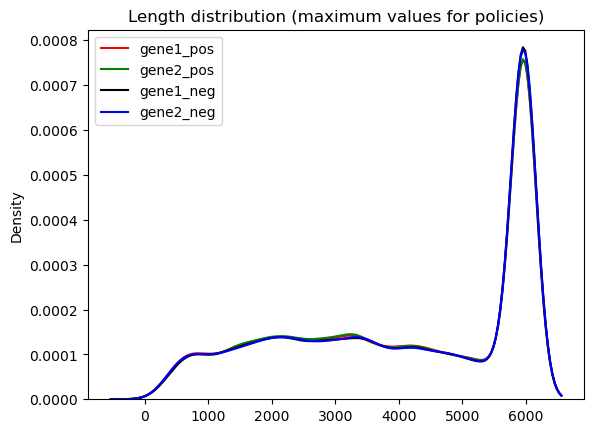

In [18]:
sns.kdeplot(l1_pos, color = 'red', label = 'gene1_pos')
sns.kdeplot(l2_pos, color = 'green', label = 'gene2_pos')
sns.kdeplot(l1_neg, color = 'black', label = 'gene1_neg')
sns.kdeplot(l2_neg, color = 'blue', label = 'gene2_neg')
plt.title(f'Length distribution (maximum values for policies)')
plt.legend()
plt.show()

### Check if dataloader preprocessing (group average) is working well.

In [19]:
import util.misc as utils

In [20]:
sampler_train = torch.utils.data.RandomSampler(dataset)
batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, 32, drop_last=False)
data_loader_train = DataLoader(dataset, batch_sampler=batch_sampler_train,
                               collate_fn=utils.collate_fn_nt2, num_workers=1)

In [21]:
TOT_SAMPLES = 200

neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []

conta = 0
for s, targets in tqdm(data_loader_train, total = TOT_SAMPLES):
    
    if targets[0]['interacting']:
        pos_len_1.append(s[0].shape[-1])
        pos_len_2.append(s[1].shape[-1])
    else:
        neg_len_1.append(s[0].shape[-1])
        neg_len_2.append(s[1].shape[-1])
        
    conta +=1
    
    if conta == TOT_SAMPLES:
        break

  0%|          | 0/200 [00:00<?, ?it/s]

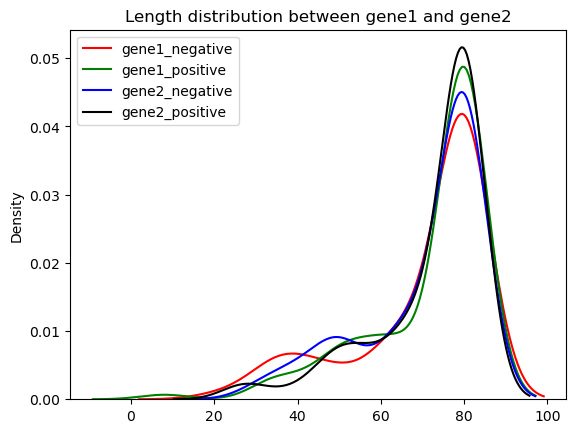

In [22]:
#pos_width_multipliers = {1_000_000: 1.}

sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

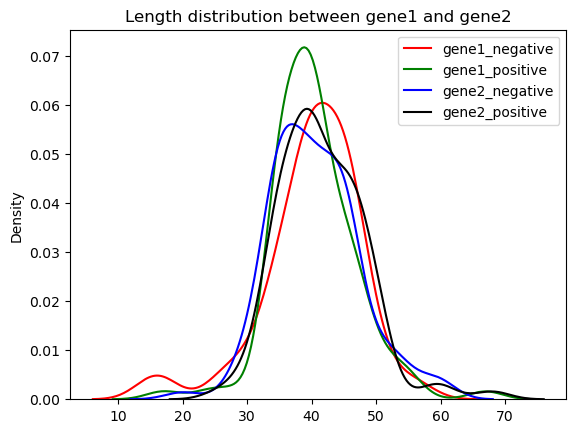

In [13]:
#{15:0.2, 50:0.2, 100:0.1, 150:0.1, 10_000_000: 0.4}

sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

# Download test set 500 nucleotides

# TODO: Do the same for validation

##### FIRST THING TO DO: GO TO data.py and change 
MAX_RNA_SIZE = 500
At the end of the creation of test500, drop the line where we put MAX_RNA_SIZE = 500

In [4]:
import util.misc as utils

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


In [5]:
file_test  = os.path.join(rna_rna_files_dir, "gene_pairs_test_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)

df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

pos_multipliers = {10_000_000:1.,}
neg_multipliers = pos_multipliers

policies_test = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]

dataset_test = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt,
    subset_file=file_test,
    augment_policies=policies_test,
    data_dir = os.path.join(embedding_dir, '32'),
    scaling_factor = 5,
    min_n_groups = np.nan,
    max_n_groups = 80,
)

/tmp/ipykernel_269678/3306950861.py:5: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))


In [6]:
test500 = []

for s in tqdm(dataset_test):
    
    gene1, gene2 = s.gene1, s.gene2

    x1, x2, y1, y2 = s.bbox.x1, s.bbox.x2, s.bbox.y1, s.bbox.y2

    seed_x1, seed_x2, seed_y1, seed_y2 = s.seed_interaction_bbox.x1, s.seed_interaction_bbox.x2, s.seed_interaction_bbox.y1, s.seed_interaction_bbox.y2
    
    interacting = s.interacting

    cdna1, cdna2 = s.gene1_info['cdna'], s.gene2_info['cdna']

    cdna1slice, cdna2slice = cdna1[x1:x2], cdna2[y1:y2]

    test500.append({
        'gene1':gene1,
        'gene2':gene2,
        'x1':x1,
        'x2':x2,
        'y1':y1,
        'y2':y2,
        'seed_x1':seed_x1,
        'seed_x2':seed_x2,
        'seed_y1':seed_y1,
        'seed_y2':seed_y2,
        'cdna1':cdna1slice,
        'cdna2':cdna2slice,
        'len1':len(cdna1slice),
        'len2':len(cdna2slice),
    })
test500 = pd.DataFrame(test500)

assert test500.len1.max() == test500.len2.max() == 500
n_rows = test500.shape[0]

  0%|          | 0/45391 [00:00<?, ?it/s]

In [7]:
# add the couples column, swap the columns that need to be swapped

with open(os.path.join(rna_rna_files_dir, f"gene_pairs_test_nt.txt"), "rb") as fp:   #Pickling
    subset_test = pickle.load(fp)

df_nt = df_nt[df_nt.couples.isin(subset_test)]

test500_1 = test500.merge(df_nt[['gene1', 'gene2', 'couples']], left_on = ['gene1', 'gene2'], right_on = ['gene1', 'gene2'])
test500_2 = test500.merge(df_nt[['gene1', 'gene2', 'couples']], left_on = ['gene1', 'gene2'], right_on = ['gene2', 'gene1'])


test500_2 = test500_2.drop(['gene1_x', 'gene2_x'], axis = 1).rename({'gene1_y':'gene1', 'gene2_y':'gene2'}, axis = 1)
where = test500_2.len1>0 #all rows
test500_2.loc[where, ['x1', 'y1']] = (test500_2.loc[where, ['y1', 'x1']].values)
test500_2.loc[where, ['x2', 'y2']] = (test500_2.loc[where, ['y2', 'x2']].values)
test500_2.loc[where, ['seed_x1', 'seed_y1']] = (test500_2.loc[where, ['seed_y1', 'seed_x1']].values)
test500_2.loc[where, ['seed_x2', 'seed_y2']] = (test500_2.loc[where, ['seed_y2', 'seed_x2']].values)
test500_2.loc[where, ['len1', 'len2']] = (test500_2.loc[where, ['len2', 'len1']].values)
test500_2.loc[where, ['cdna1', 'cdna2']] = (test500_2.loc[where, ['cdna2', 'cdna1']].values)

#shuffling
test500 = pd.concat([test500_1, test500_2], axis = 0).sample(frac=1).reset_index(drop = True)

In [8]:
test500.head(3)

,gene1,gene2,x1,x2,y1,y2,seed_x1,seed_x2,seed_y1,seed_y2,cdna1,cdna2,len1,len2,couples
0,ENSG00000083844_3064_9034,ENSG00000237718_0_1326,3368,3868,662,1162,3763,3781,1058,1079,CAAAGAATTTTAAATAAAAATTCAAGTGTGGTTTCTACTGAATGCA...,CACCACCATGCCTGGCTAATTTTTTCTATTTTGTAGAGATGGAGTC...,500,500,305904
1,ENSMUSG00000027434_0_2120,ENSMUSG00000036766_0_3632,1070,1570,3129,3629,1493,1512,3604,3620,CAGGCAGGCATCCCCTTTTCCGCCTACAGCGCGCAGTCGCTGCAGC...,GACGTGGCGTCCGAGATGTTTGTTTTGTGAAAAAAGAAAACTAGTT...,500,500,298653
2,ENSG00000197081_7783_13753,ENSG00000226200_5634_11604,3544,4044,1751,2251,3661,3695,1801,1819,TTCTCCTGCCTCAGCCTCCCTAGTAGCTGGGATTAAAGGCACGCAC...,AAGCAGCCTAATAAAGGTTCCCAAGTCCAAACCATGAATCCAAACG...,500,500,321748


In [9]:
n_rows

45391

In [10]:
assert abs(n_rows - test500.shape[0]) < 10 # I Know there are some duplicates in df_nt 
# with respect to this key 
# df_nt['key'] = df_nt['gene1'] + '_' + df_nt['gene2'] 
# but they are few

In [11]:
test500.to_csv(os.path.join(metadata_dir, 'test500.csv'), index = False)

# Find a way to balance degrees

In [3]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt.txt"), "rb") as fp:  # Unpickling
    subset_train = pickle.load(fp)

/tmp/ipykernel_596323/2913665339.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))


In [4]:
train = df_nt[df_nt.couples.isin(subset_train)].drop(['diff1', 'diff2', 'diff', 'problematic'], axis = 1)

In [5]:
def balance_df(df):
    positives = df[df.interacting]
    negatives = df[df.interacting == False]
    if negatives.shape[0]>=positives.shape[0]:
        negatives_to_sample = positives.shape[0]
        df_sampled = pd.concat([positives, negatives.sample(negatives_to_sample)],axis = 0)
    else:
        positives_to_sample = negatives.shape[0]
        df_sampled = pd.concat([negatives, positives.sample(positives_to_sample)],axis = 0)
    return df_sampled.reset_index(drop = True)

def obtain_pair_diff_distribution(sampled, gene_count_real):
    sampled = sampled.merge(gene_count_real[['gene', 'diff']], left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff1'}, axis =1)
    sampled = sampled.merge(gene_count_real[['gene', 'diff']], left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff2'}, axis =1)
    sampled['diff'] = sampled['diff1'] + sampled['diff2']
    return sampled

def update_df(updt_df, subsetted_sampled):
    merged_df = updt_df.merge(subsetted_sampled[['couples', 'diff1', 'diff2']], on = 'couples', how='left').fillna(0)
    summed_df = pd.DataFrame()
    summed_df['couples'] = merged_df['couples']
    summed_df['diff1'] = merged_df['diff1_x'] + merged_df['diff1_y']
    summed_df['diff2'] = merged_df['diff2_x'] + merged_df['diff2_y']
    return summed_df

In [6]:
train_sampled = balance_df(train)

In [7]:
gene_count_real = obtain_gene_count_real(train_sampled)

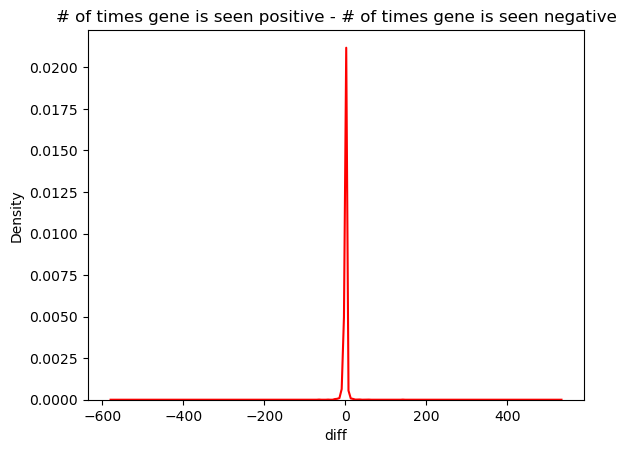

In [10]:
sns.kdeplot(gene_count_real['diff'], color = 'red')
plt.title(f'# of times gene is seen positive - # of times gene is seen negative')
plt.show()

In [11]:
train_sampled = obtain_pair_diff_distribution(train_sampled, gene_count_real)

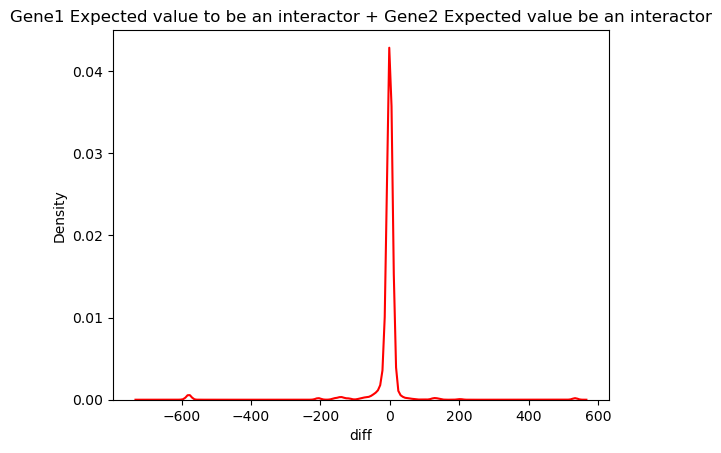

In [12]:
sns.kdeplot(train_sampled['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

In [13]:
tolerance = 100

subsetted = train_sampled[(train_sampled['diff']<tolerance)&(train_sampled['diff']>-tolerance)].drop(['diff','diff1', 'diff2'], axis = 1)

In [14]:
subsetted_sampled = balance_df(subsetted)

In [15]:
gene_count_real = obtain_gene_count_real(subsetted_sampled)

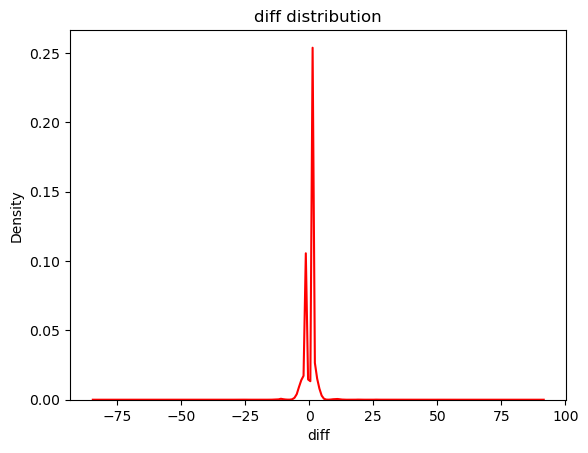

In [16]:
sns.kdeplot(gene_count_real['diff'], color = 'red')
plt.title(f'diff distribution')
plt.show()

In [17]:
subsetted_sampled = obtain_pair_diff_distribution(subsetted_sampled, gene_count_real)

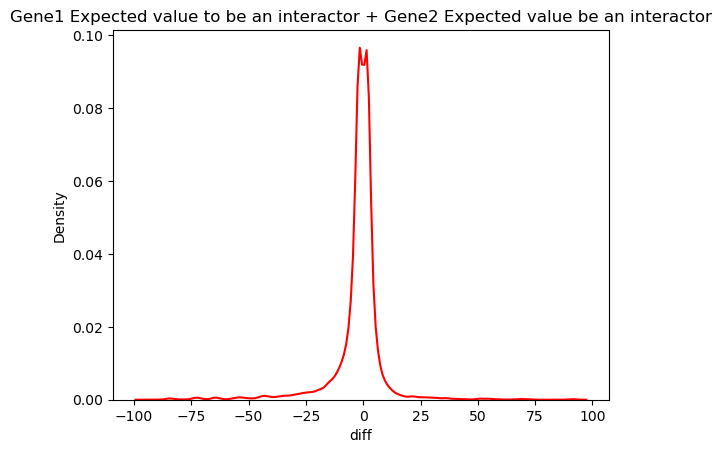

In [18]:
sns.kdeplot(subsetted_sampled['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

### Sampling way

In [19]:
n_epochs = 25
tolerance = 40

updt_df = pd.DataFrame(train.couples).drop_duplicates().reset_index(drop=True)
updt_df['diff1'] = 0
updt_df['diff2'] = 0

for i in tqdm(range(n_epochs)):
    train_sampled = balance_df(train.copy())
    gene_count_real = obtain_gene_count_real(train_sampled)
    train_sampled = obtain_pair_diff_distribution(train_sampled, gene_count_real)
    # if i >0:
    #     train_sampled = obtain_updated_pair_diff_distribution(train_sampled, updt_df)
    subsetted = train_sampled[(train_sampled['diff']<tolerance)&(train_sampled['diff']>-tolerance)].drop(['diff','diff1', 'diff2'], axis = 1)
    subsetted_sampled = balance_df(subsetted)
    gene_count_real = obtain_gene_count_real(subsetted_sampled)
    subsetted_sampled = obtain_pair_diff_distribution(subsetted_sampled, gene_count_real)
    updt_df = update_df(updt_df, subsetted_sampled)
updt_df['diff'] = updt_df['diff1'] + updt_df['diff2']

  0%|          | 0/25 [00:00<?, ?it/s]

12742
232397


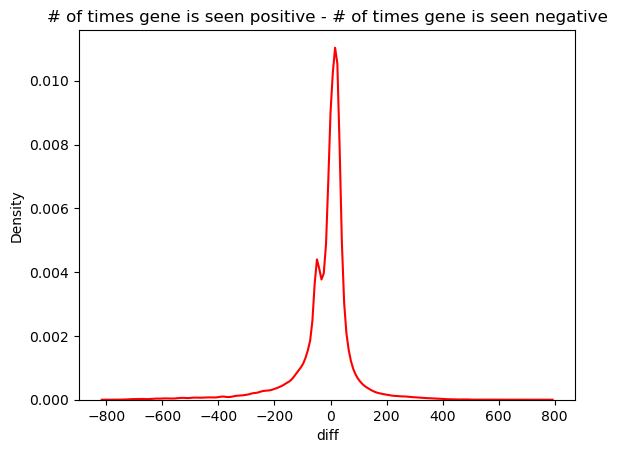

In [21]:
#40
print(updt_df[(updt_df['diff1'] == 0) & (updt_df['diff2'] == 0)].shape[0])
print(updt_df.shape[0])
sns.kdeplot(updt_df['diff'], color = 'red')
plt.title(f'# of times gene is seen positive - # of times gene is seen negative')
plt.show()

### Standard way

In [22]:
updt_df = pd.DataFrame(train.couples).drop_duplicates().reset_index(drop=True)
updt_df['diff1'] = 0
updt_df['diff2'] = 0
for i in tqdm(range(n_epochs)):
    train_sampled = balance_df(train)
    gene_count_real = obtain_gene_count_real(train_sampled)
    train_sampled = obtain_pair_diff_distribution(train_sampled, gene_count_real)
    updt_df = update_df(updt_df, train_sampled)

  0%|          | 0/25 [00:00<?, ?it/s]

In [23]:
updt_df['diff'] = updt_df['diff1'] + updt_df['diff2']
print(updt_df[(updt_df['diff1'] == 0) & (updt_df['diff2'] == 0)].shape[0])
print(updt_df.shape[0])

68
232397


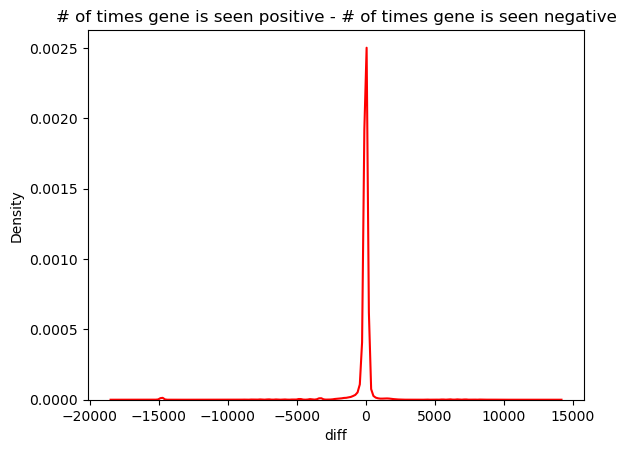

In [24]:
sns.kdeplot(updt_df['diff'], color = 'red')
plt.title(f'# of times gene is seen positive - # of times gene is seen negative')
plt.show()

Extra

In [8]:
unbalanced_ratio = train.interacting.value_counts()[True]/train.interacting.value_counts()[False]

In [8]:
gene_count = create_gene_count(train, unbalanced_ratio)
train = train.merge(gene_count[['gene', 'abs_diff_weighted']], left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'abs_diff_weighted':'abs_diff_weighted1'}, axis =1)
train = train.merge(gene_count[['gene', 'abs_diff_weighted']], left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'abs_diff_weighted':'abs_diff_weighted2'}, axis =1)
train['abs_diff_weighted'] = train['abs_diff_weighted1'] + train['abs_diff_weighted2']

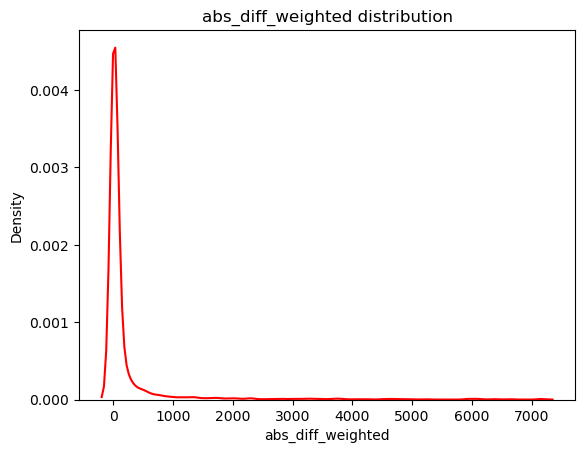

In [9]:
sns.kdeplot(train[train['abs_diff_weighted'] <= train['abs_diff_weighted'].quantile(0.95)].abs_diff_weighted, color = 'red')
plt.title(f'abs_diff_weighted distribution')
plt.show()

In [10]:
pos_multipliers = {100_000:1.}
neg_multipliers = pos_multipliers

policies_train = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalanced_ratio,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]
    
    
dataset_train = RNADataset(
        gene2info=df_genes_nt,
        interactions=train,
        subset_file='',
        augment_policies=policies_train,
)

In [49]:
epochs = 25
gene_count_pos_list = []
gene_count_neg_list = []
for i in tqdm(range(epochs)):
    for s in dataset_train:
        if s.interacting:
            gene_count_pos_list.append(s.gene1)
            gene_count_pos_list.append(s.gene2)
        else:
            gene_count_neg_list.append(s.gene1)
            gene_count_neg_list.append(s.gene2)

  0%|          | 0/25 [00:00<?, ?it/s]

In [50]:
gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
gene_count_real = gene_count_res.groupby('gene').sum()
gene_count_real['not_interacting'] = gene_count_res.groupby('gene').count()['interacting'] - gene_count_real['interacting']
gene_count_real['diff'] = gene_count_real['not_interacting'] - gene_count_real['interacting']
gene_count_real['total'] = gene_count_real['not_interacting'] + gene_count_real['interacting']

In [68]:
gene_count_real[gene_count_real['total'] == gene_count_real['total'].max()]

,interacting,not_interacting,diff,total
gene,,,,
ENSMUSG00000097971_0_3329,28775,14525,-14250,43300


Compare with expected gene_count

In [51]:
comparison = gene_count_real.reset_index()[['gene', 'diff']].merge(gene_count[['gene', 'diff_weighted']])

In [63]:
comparison.loc[(comparison['diff'] - comparison['diff_weighted']).argmax()]

gene             ENSMUSG00000097971_0_3329
diff                                -14250
diff_weighted              -1005845.705705
Name: 134829, dtype: object

In [64]:
comparison[comparison['diff'] == comparison['diff'].max()]

,gene,diff,diff_weighted
130766,ENSMUSG00000063087_0_3493,13650,302679.795783


In [59]:
comparison[comparison.gene == 'ENSMUSG00000097971_0_3329']

,gene,diff,diff_weighted
134829,ENSMUSG00000097971_0_3329,-14250,-1.005846e+06


In [70]:
gene_count[gene_count.gene == 'ENSMUSG00000097971_0_3329']

,gene,interacting,not_interacting,diff,abs_diff,tot,abs_diff_weighted,diff_weighted
195395,ENSMUSG00000097971_0_3329,1151,564.761272,-586.238728,586.238728,1715.761272,1.005846e+06,-1.005846e+06


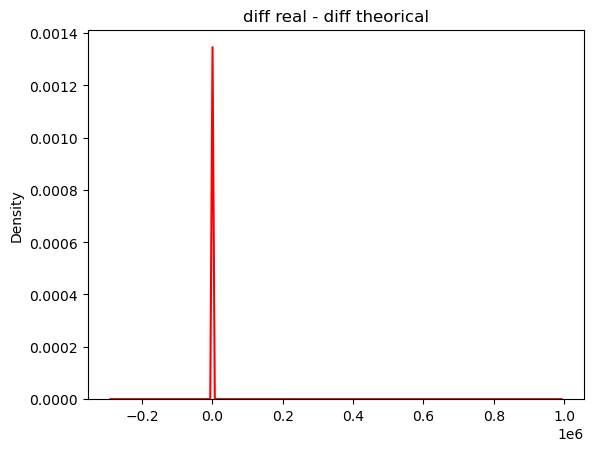

In [54]:
sns.kdeplot(comparison['diff'] - comparison['diff_weighted'], color = 'red')
plt.title(f'diff real - diff theorical')
plt.show()

In [ ]:
tolerance = 50
print(f'before:{df_meta.shape[0]}')
problematics = df_meta[(df_meta['diff']>tolerance)|(df_meta['diff']<-tolerance)]

df_meta['problematic'] = False
df_meta.loc[ df_meta.id_sample.isin(set(problematics.id_sample)), 'problematic'] = True
subsetted = df_meta[(df_meta['diff']<tolerance)&(df_meta['diff']>-tolerance)]
print(f'after:{subsetted.shape[0]}')
perc = np.round(100 - subsetted.shape[0]/original_shape*100, 2)
print(f'In total, I would loose the {perc}% of the pairs by keeping only the not problematic pairs')

df_meta_clean = subsetted.reset_index(drop = True).drop(['diff', 'diff1', 'diff2'], axis =1)
unbalanced_ratio = df_meta_clean.interacting.value_counts()[True]/df_meta_clean.interacting.value_counts()[False]
print(f'If I cleen the data I would have an unbalanced_ratio:{unbalanced_ratio:.2f}')
gene_count_new = create_gene_count(df_meta_clean, unbalanced_ratio)
weighted_average = np.round(gene_count_new['abs_diff_weighted'].sum()/gene_count_new['tot'].sum(),2)
print(f'If I cleen the data I would have {weighted_average=}')

In [80]:
gene_count = create_gene_count(train, unbalanced_ratio)

In [71]:
gene_count

,gene,interacting,not_interacting,diff,abs_diff,tot,abs_diff_weighted
0,ENSG00000000003_0_3796,6,8.000785,2.000785,2.000785,14.000785,28.012556
1,ENSG00000000005_0_1205,1,1.411903,0.411903,0.411903,2.411903,0.993471
2,ENSG00000000419_0_1161,3,2.353172,-0.646828,0.646828,5.353172,3.462582
3,ENSG00000000457_128_6098,0,0.470634,0.470634,0.470634,0.470634,0.221497
4,ENSG00000000457_175_6145,0,0.470634,0.470634,0.470634,0.470634,0.221497
...,...,...,...,...,...,...,...
197915,ENSMUSG00000118407_0_974,1,0.941269,-0.058731,0.058731,1.941269,0.114013
197916,ENSMUSG00000118454_0_1944,0,0.470634,0.470634,0.470634,0.470634,0.221497
197917,ENSMUSG00000118506_0_3097,3,3.765075,0.765075,0.765075,6.765075,5.175791
197918,ENSMUSG00000118559_0_3972,1,0.470634,-0.529366,0.529366,1.470634,0.778503
